#Dependencies

In [ ]:
!pip3 install flair
!pip install contractions
!pip install beautifulsoup4
!pip install bertopic

     |████████████████████████████████| 322 kB 10.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 48 kB 4.0 MB/s 
     |████████████████████████████████| 788 kB 26.9 MB/s 
     |████████████████████████████████| 64 kB 1.5 MB/s 
     |████████████████████████████████| 61 kB 125 kB/s 
     |████████████████████████████████| 19.7 MB 27.0 MB/s 
     |████████████████████████████████| 1.2 MB 24.0 MB/s 
     |████████████████████████████████| 3.4 MB 15.9 MB/s 
     |████████████████████████████████| 981 kB 10.3 MB/s 
     |████████████████████████████████| 62 kB 247 kB/s 
     |████████████████████████████████| 895 kB 50.5 MB/s 
     |████████████████████████████████| 596 kB 32.2 MB/s 
     |████████████████████████████████| 3.3 MB 35.2 MB/s 
  Created wheel for gdown: filename=gdown-3.12.2-py3-none-any.whl size=9704 sha256=869f6d139907f75f3ef112517a08d365341a569bf4f6

#Imports


In [ ]:
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import flair

import os
from ast import literal_eval
import bz2
import json
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

nltk.download('stopwords')
nltk.download('vader_lexicon')

from nltk.corpus import stopwords
import contractions
from bs4 import BeautifulSoup
import unicodedata
import re
import numpy as np

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
from nltk.stem.porter import *
stemmer = PorterStemmer()
#print(STOPWORDS)

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


#Preprocess

In [ ]:
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def expand_contractions(text):
    return contractions.fix(text)

def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-Z\s]'
    text = re.sub(pattern, '', text)
    return text

def pre_process_document(document):
    # print(document)
    # strip HTML
    # document = strip_html_tags(document)
    # document = re.sub(r'[hH][tT][tT][pP][Ss]?:\/\/.*[\r\n]* ?', '', document)
    st=re.search(r'\[([^]]+)\]', document)
    # print(document)
    if(st):
      st=st.group(1)
      document = document.replace(st,"")
      # print(st)
    
    document = ' '.join(word for word in document.split() )#if word.lower() not in STOPWORDS) 
    # document = st+document[]
    document = REPLACE_BY_SPACE_RE.sub(' ', document) 
    # lower case
    document = document.lower()
    # remove links
    
    # remove extra newlines (often might be present in really noisy text)
    document = document.translate(document.maketrans("\n\t\r", "   "))
    # remove accented characters
    # document = remove_accented_chars(document)
    # expand contractions    
    # document = expand_contractions(document)  
    # remove special characters and\or digits    
    # insert spaces between special characters to isolate them    
    #special_char_pattern = re.compile(r'([{.(-)!}])')
    #document = special_char_pattern.sub(" \\1 ", document)
    document = remove_special_characters(document, remove_digits=False)  
    # remove extra whitespace
    document = re.sub(' +', ' ', document)
    # document= ' '.join(stemmer.stem(i) for i in document.split())
    document = document.strip()
    if(st):
      sb=st.lower().strip()
      if(len(sb)>1):
        sb+=" "
      document = sb + document
    
    # document = ' '.join(word for word in document.split() if word.lower() not in STOPWORDS) 
    # print(document)
    return document

# a=pre_process_document(appended_data.iloc[4]['quotation'])

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
data=pd.read_csv('/content/drive/MyDrive/DATA_parse/quotes_2016_parse.csv', encoding='UTF-8', compression='bz2', index_col=0, chunksize=100000)
data = next(data)
#print(len(data))
#n = len(data) // 100000
#data = data.iloc[::n]
print(len(data))
data.head()

100000
100000


,quoteID,quotation,speaker,date,numOccurrences,urls_parse,aliases,nationality,occupation,party
0,2016-12-26-000040,[ ] and Chris [ Jones ] were in there a lot an...,Andy Reid,2016-12-26 20:05:00,1,www.kcchiefs.com,['Andrew Walter Reid'],['United States of America'],"['American football player', 'head coach']",NaN
1,2016-07-31-000006,[ And ] I don't know if we have enough time to...,Mike Howe,2016-07-31 08:22:12,2,www.peninsuladailynews.com,NaN,['United States of America'],['singer'],NaN
2,2016-07-11-000226,[ I ] mmigration has been and continues to be ...,Hillary Clinton,2016-07-11 17:26:06,1,www.breitbart.com,['Hillary Rodham Clinton' 'Hillary Rodham' 'Hi...,['United States of America'],"['politician', 'lawyer', 'diplomat', 'writer',...","['Democratic Party', 'Republican Party']"
3,2016-05-26-000371,[ It is ] the process of understanding what ki...,Bruce Maxwell,2016-05-26 15:21:37,1,www.scout.com,NaN,NaN,NaN,NaN
4,2016-02-12-000118,[ It ] would give us more flexibility in terms...,Bob McDonald,2016-02-12 18:30:52,1,federalnewsradio.com,NaN,['Canada'],['ice hockey player'],NaN


In [ ]:
data['quotation'] = data['quotation'].apply(pre_process_document)
data.dropna(subset=['quotation'], inplace=True)
print(len(data))
data.head()

100000


,quoteID,quotation,speaker,date,numOccurrences,urls_parse,aliases,nationality,occupation,party
0,2016-12-26-000040,andchris jones wereintherealotandtamba hali wa...,Andy Reid,2016-12-26 20:05:00,1,www.kcchiefs.com,['Andrew Walter Reid'],['United States of America'],"['American football player', 'head coach']",NaN
1,2016-07-31-000006,and i dont know if we have enough time to sell...,Mike Howe,2016-07-31 08:22:12,2,www.peninsuladailynews.com,NaN,['United States of America'],['singer'],NaN
2,2016-07-11-000226,immigration has been and continues to be good ...,Hillary Clinton,2016-07-11 17:26:06,1,www.breitbart.com,['Hillary Rodham Clinton' 'Hillary Rodham' 'Hi...,['United States of America'],"['politician', 'lawyer', 'diplomat', 'writer',...","['Democratic Party', 'Republican Party']"
3,2016-05-26-000371,it is the process of understanding what kind o...,Bruce Maxwell,2016-05-26 15:21:37,1,www.scout.com,NaN,NaN,NaN,NaN
4,2016-02-12-000118,it would give us more flexibility in terms of ...,Bob McDonald,2016-02-12 18:30:52,1,federalnewsradio.com,NaN,['Canada'],['ice hockey player'],NaN


#NLTK Sentiment Analyzer

In [ ]:
nltk_sentiment = SentimentIntensityAnalyzer()

def classify_sentiment_nltk(doc):
  #  print(doc)
   scores = nltk_sentiment.polarity_scores(doc)
   neg_sc=scores['neg']	
   neu_sc=scores['neu']
   pos_sc=scores['pos']
   compound_sc=scores['compound']
   sentiment=np.argmax(np.array([neg_sc,neu_sc,pos_sc,compound_sc]))
   scores['sentiment'] = sentiment
   return scores
  

applied_df = data.apply(lambda row: classify_sentiment_nltk(row.quotation), axis='columns', result_type='expand')
applied_df.head()

,neg,neu,pos,compound,sentiment
0,0.0,1.000,0.000,0.0000,1.0
1,0.0,1.000,0.000,0.0000,1.0
2,0.0,0.775,0.225,0.4404,1.0
3,0.0,1.000,0.000,0.0000,1.0
4,0.0,0.727,0.273,0.8856,3.0


In [ ]:
print(data.shape,applied_df.shape)
df = pd.concat([data, applied_df],axis='columns')
df.head()

(100000, 10) (100000, 5)


,quoteID,quotation,speaker,date,numOccurrences,urls_parse,aliases,nationality,occupation,party,neg,neu,pos,compound,sentiment
0,2016-12-26-000040,andchris jones wereintherealotandtamba hali wa...,Andy Reid,2016-12-26 20:05:00,1,www.kcchiefs.com,['Andrew Walter Reid'],['United States of America'],"['American football player', 'head coach']",NaN,0.0,1.000,0.000,0.0000,1.0
1,2016-07-31-000006,and i dont know if we have enough time to sell...,Mike Howe,2016-07-31 08:22:12,2,www.peninsuladailynews.com,NaN,['United States of America'],['singer'],NaN,0.0,1.000,0.000,0.0000,1.0
2,2016-07-11-000226,immigration has been and continues to be good ...,Hillary Clinton,2016-07-11 17:26:06,1,www.breitbart.com,['Hillary Rodham Clinton' 'Hillary Rodham' 'Hi...,['United States of America'],"['politician', 'lawyer', 'diplomat', 'writer',...","['Democratic Party', 'Republican Party']",0.0,0.775,0.225,0.4404,1.0
3,2016-05-26-000371,it is the process of understanding what kind o...,Bruce Maxwell,2016-05-26 15:21:37,1,www.scout.com,NaN,NaN,NaN,NaN,0.0,1.000,0.000,0.0000,1.0
4,2016-02-12-000118,it would give us more flexibility in terms of ...,Bob McDonald,2016-02-12 18:30:52,1,federalnewsradio.com,NaN,['Canada'],['ice hockey player'],NaN,0.0,0.727,0.273,0.8856,3.0


In [ ]:
rev_label=['negative','neutral','positive','compound']
temp = df[['quotation','sentiment']]
temp['sentiment'] = temp['sentiment'].map(lambda row: rev_label[int(row)])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


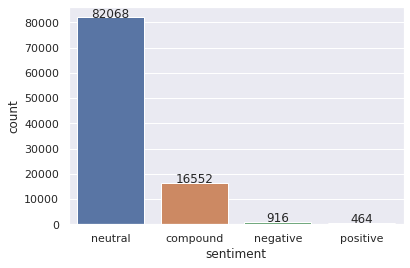

In [ ]:
sns.set(style="darkgrid")
ax = sns.countplot(x='sentiment', data=temp)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

Neutral Words


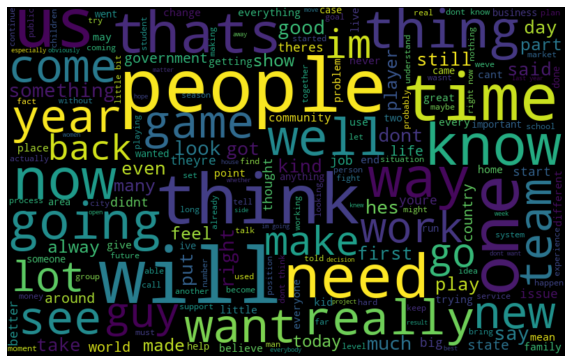

Negative Words


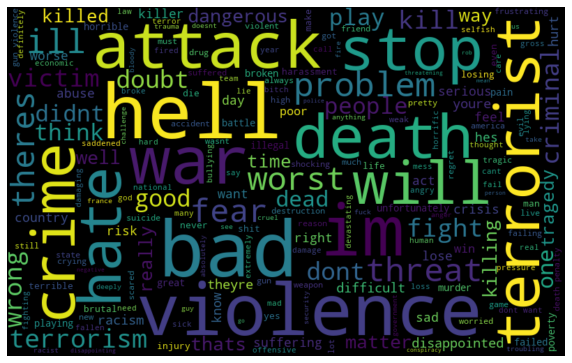

Positive Words


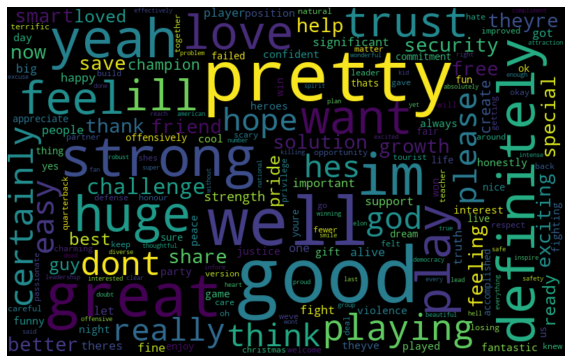

Compound Words


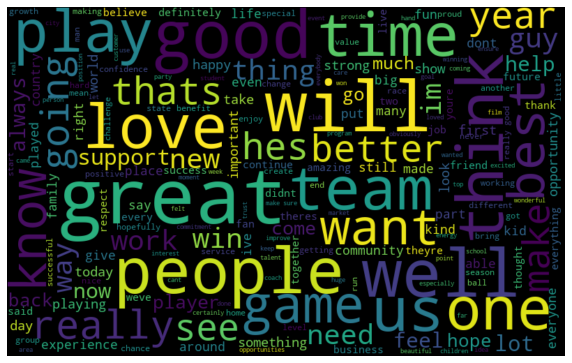

In [ ]:
print("Neutral Words")

neu_words =' '.join([text for text in df['quotation'][df['sentiment'] == 1]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(neu_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

print("Negative Words")

neg_words =' '.join([text for text in df['quotation'][df['sentiment'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(neg_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

print("Positive Words")

pos_words =' '.join([text for text in df['quotation'][df['sentiment'] == 2]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(pos_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

print("Compound Words")

compound_words =' '.join([text for text in df['quotation'][df['sentiment'] == 3]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(compound_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


#Flair Sentiment Analyzer

In [ ]:

#flair.device = torch.device('cuda')
flair_sentiment = flair.models.TextClassifier.load('sentiment-fast')
#may need to use a faster model or batch processing 
def classify_sentiment_flair(doc):
  #  print(doc)
   s = flair.data.Sentence(doc)
   flair_sentiment.predict(s)
  #  print(s)
   #scores = [(sent.labels[0].values, sent.labels[0].score) for sent in s]
   if len(s) > 0:
    scores = s.labels[0]
    return scores.value
   else:
     return 0
  

applied_df_flair= data.copy()
applied_df_flair['sentiment'] = applied_df_flair['quotation'].apply(lambda quote: classify_sentiment_flair(quote))
applied_df_flair.head()

2021-12-16 08:53:04,274 loading file /root/.flair/models/sentiment-en-mix-ft-rnn_v8.pt
2021-12-16 08:57:53,374 Warning: An empty Sentence was created! Are there empty strings in your dataset?


,quoteID,quotation,speaker,date,numOccurrences,urls_parse,aliases,nationality,occupation,party,sentiment
0,2016-12-26-000040,andchris jones wereintherealotandtamba hali wa...,Andy Reid,2016-12-26 20:05:00,1,www.kcchiefs.com,['Andrew Walter Reid'],['United States of America'],"['American football player', 'head coach']",NaN,POSITIVE
1,2016-07-31-000006,and i dont know if we have enough time to sell...,Mike Howe,2016-07-31 08:22:12,2,www.peninsuladailynews.com,NaN,['United States of America'],['singer'],NaN,NEGATIVE
2,2016-07-11-000226,immigration has been and continues to be good ...,Hillary Clinton,2016-07-11 17:26:06,1,www.breitbart.com,['Hillary Rodham Clinton' 'Hillary Rodham' 'Hi...,['United States of America'],"['politician', 'lawyer', 'diplomat', 'writer',...","['Democratic Party', 'Republican Party']",POSITIVE
3,2016-05-26-000371,it is the process of understanding what kind o...,Bruce Maxwell,2016-05-26 15:21:37,1,www.scout.com,NaN,NaN,NaN,NaN,NEGATIVE
4,2016-02-12-000118,it would give us more flexibility in terms of ...,Bob McDonald,2016-02-12 18:30:52,1,federalnewsradio.com,NaN,['Canada'],['ice hockey player'],NaN,POSITIVE


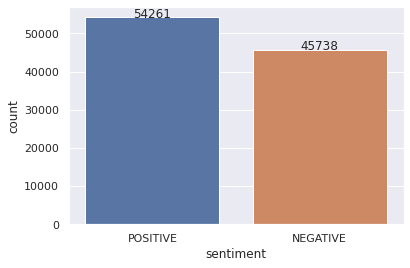

In [ ]:
applied_df_flair = applied_df_flair[(applied_df_flair['sentiment'] == 'POSITIVE') | (applied_df_flair['sentiment'] == 'NEGATIVE')]
sns.set(style="darkgrid")
ax = sns.countplot(x='sentiment', data=applied_df_flair[['quotation','sentiment']])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

Positive Words


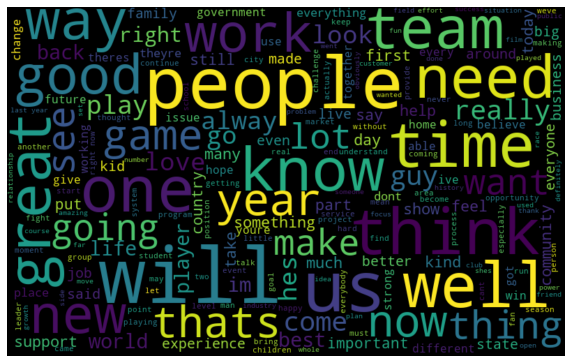

Negative Words


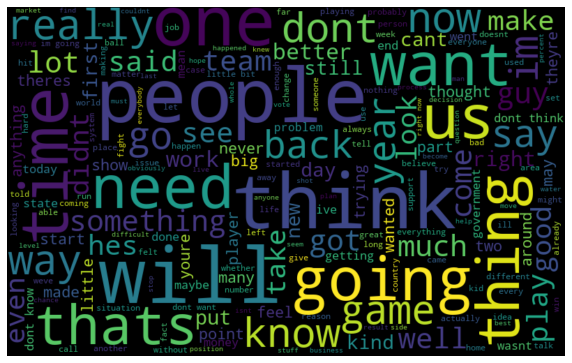

In [ ]:
df=applied_df_flair.copy()
print("Positive Words")

neu_words =' '.join([text for text in df['quotation'][df['sentiment'] == 'POSITIVE']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(neu_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

print("Negative Words")

neg_words =' '.join([text for text in df['quotation'][df['sentiment'] == 'NEGATIVE']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(neg_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# BERTtopic

In [ ]:
from bertopic import BERTopic
topic_model = BERTopic(verbose=True)

In [ ]:
dataset = data[['quotation', 'date']]
dataset.head()

,quotation,date
0,andchris jones wereintherealotandtamba hali wa...,2016-12-26 20:05:00
1,and i dont know if we have enough time to sell...,2016-07-31 08:22:12
2,immigration has been and continues to be good ...,2016-07-11 17:26:06
3,it is the process of understanding what kind o...,2016-05-26 15:21:37
4,it would give us more flexibility in terms of ...,2016-02-12 18:30:52


In [ ]:
def remove_stop(document):
    document = ' '.join(word for word in document.split() if word.lower() not in STOPWORDS) 
    return document
#dataset['quotation']=dataset['quotation_x'].apply(lambda x: remove_stop(x))
dataset['quotation']=dataset['quotation'].apply(lambda x: remove_stop(x))
dataset.head()

,quotation,date
0,andchris jones wereintherealotandtamba hali wa...,2016-12-26 20:05:00
1,dont know enough time sell community,2016-07-31 08:22:12
2,immigration continues good economy,2016-07-11 17:26:06
3,process understanding kind hitter youre going,2016-05-26 15:21:37
4,would give us flexibility terms paying competi...,2016-02-12 18:30:52


In [ ]:
#sample=dataset.sample(n=100000,random_state=0)# sample size since model runs out of ram 
sample = dataset
sample.reset_index(inplace=True,drop=True)
sample.head()

,quotation,date
0,andchris jones wereintherealotandtamba hali wa...,2016-12-26 20:05:00
1,dont know enough time sell community,2016-07-31 08:22:12
2,immigration continues good economy,2016-07-11 17:26:06
3,process understanding kind hitter youre going,2016-05-26 15:21:37
4,would give us flexibility terms paying competi...,2016-02-12 18:30:52


In [ ]:
data=sample['quotation'].values.tolist()
timestamps=sample['date'].values.tolist()

In [ ]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words="english", min_df=10)
topic_model = BERTopic(vectorizer_model=vectorizer_model,verbose=True, calculate_probabilities=False)# low_memory=True,

In [ ]:
topics, probs = topic_model.fit_transform(data)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/3125 [00:00<?, ?it/s]

2021-12-16 09:23:44,546 - BERTopic - Transformed documents to Embeddings
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
2021-12-16 09:26:52,263 - BERTopic - Reduced dimensionality with UMAP
2021-12-16 09:27:09,813 - BERTopic - Clustered UMAP embeddings with HDBSCAN


In [ ]:
freq = topic_model.get_topic_info(); freq.head(10)

,Topic,Count,Name
0,-1,53451,-1_hes_game_team_play
1,0,3083,0_students_school_education_schools
2,1,1079,1_music_song_songs_band
3,2,908,2_thought_answer_dont know_think dont
4,3,615,3_film_movie_actor_movies
5,4,605,4_race_racing_races_car
6,5,603,5_food_eat_restaurant_restaurants
7,6,587,6_fight_fighting_fighter_fighters
8,7,531,7_pitch_baseball_strikes_hit
9,8,520,8_coach_coaches_head_staff


In [ ]:
topics_over_time = topic_model.topics_over_time(data, topics, timestamps, nr_bins=20)
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=10)

20it [00:16,  1.24it/s]


In [ ]:
#topics_over_time.write_html("topics_over_time_2020.html", include_plotlyjs="cdn")
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=10).write_html("topics_over_time_2016.html", include_plotlyjs="cdn")

In [ ]:
fig = topic_model.visualize_topics(); fig

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
topic_nr = freq.iloc[0]["Topic"]  # We select a frequent topic
topic_model.get_topic(topic_nr)   # You can select a topic number as shown above

[('hes', 0.0012958032851307791),
 ('game', 0.0011983126035561818),
 ('team', 0.0011950382549945583),
 ('play', 0.0011791193403659064),
 ('guys', 0.001126155662101383),
 ('good', 0.0011214716194582477),
 ('going', 0.0011059470750205247),
 ('got', 0.0010937683669798581),
 ('people', 0.0010869517050102675),
 ('weve', 0.001086771481170162)]

topics_over_time.write_html("topics_over_time.html", include_plotlyjs="cdn")

In [ ]:
fig.write_html("Intertropic_distance_2016.html", include_plotlyjs="cdn")